<a href="https://colab.research.google.com/github/noahehrhardt/hotdognothotdog/blob/main/hotdog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotdog Classifier
### Noah Ehrhardt
This project is inspired by Silicon Valley, a show that inspired me study computer science. In one episode, a character has to make a camera-based "shazam for food" app that identifies and gives information about pictures of food. However, he ends up only making an app that recognizes hotdogs and anything that is not a hotdog. I have attempted to recreate Jian Yang's app with various image classification models.



##Data

This project is a reimplementation of Sanjay Chouhan's project. I copied his data processing, but played around with the models. Here is the [link](https://www.kaggle.com/datasets/yashvrdnjain/hotdognothotdog?resource=download) to the data.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Unzip:

In [ ]:
!unzip /content/drive/MyDrive/cv_project/data/archive.zip

Archive:  /content/drive/MyDrive/cv_project/data/archive.zip
replace hotdog-nothotdog/test/hotdog/1501.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Data Preprocessing

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
PATH = '/content/hotdog-nothotdog/'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [ ]:
class_names = train_dataset.class_names
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [ ]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 644 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

Example:

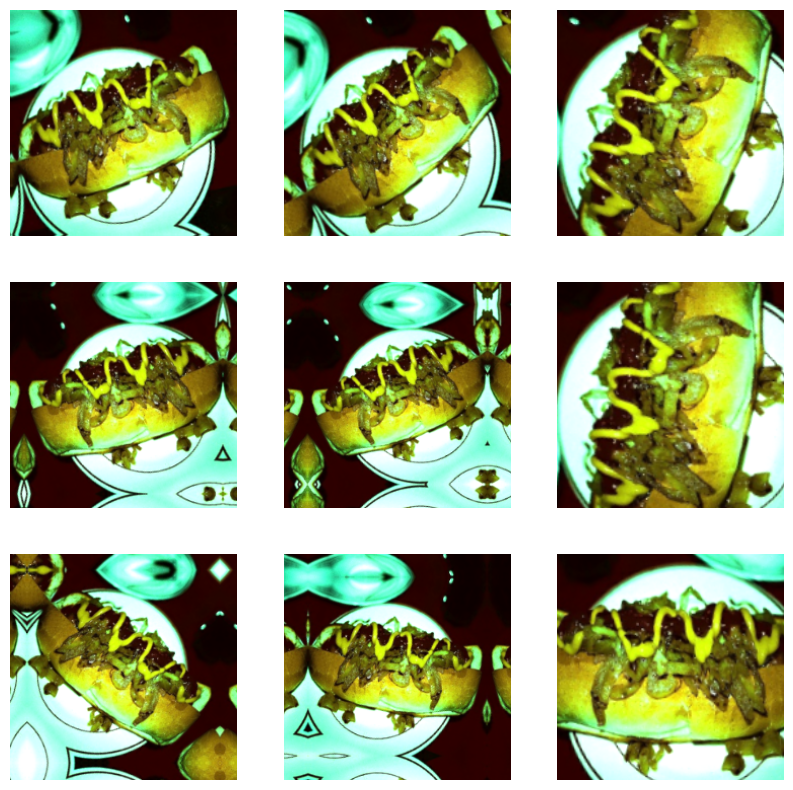

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 223)
        plt.axis('off')

In [ ]:
rescale = preprocessing.Rescaling(1./223)

##Models

###MobileNetV2

MobileNetV2 is a lightweight model meant for mobile devices. It uses a series of bottleneck blocks that scale the input up, run a depthwise convolution, and compresses the input back into the lower dimensional representation.

In [ ]:
def expansion(x, t, filters):
    x = layers.Conv2D(t*filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6)(x)
    return x

def depthwise(x, stride):
    x = layers.DepthwiseConv2D(3, strides=(stride, stride), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6)(x)
    return x

def projection(x, out_channels):
    x = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return x

def bottleneck(x, t, filters, stride, out_channels):
    y = expansion(x, t, filters)
    y = depthwise(y, stride)
    y = projection(y, out_channels)
    if y.shape[-1] == x.shape[-1]:
        y = layers.add([x, y])
    return y

def MobileNetV2():
    inputs = tf.keras.Input(shape=(224, 224, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)

    x = layers.Conv2D(32, 3, (2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6)(x)
    x = depthwise(x, stride=1)
    x = projection(x, out_channels=16)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 2,  out_channels = 24)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 24)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 2,  out_channels = 32)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 32)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 32)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 2,  out_channels = 64)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 64)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 64)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 64)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 96)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 96)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1,  out_channels = 96)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 2, out_channels = 160)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1, out_channels = 160)
    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1, out_channels = 160)

    x = bottleneck(x, t = 6, filters = x.shape[-1], stride = 1, out_channels = 320)

    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dropout(.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name='MobileNetV2')
    return model

In [ ]:
mobilenet_model = MobileNetV2()
mobilenet_model.summary()

Model: "MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 224, 224, 3)          0         ['image[0][0]']               
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['sequential_1[1][0]']        
                                                                                                  
 conv2d_35 (Conv2D)          (None, 112, 112, 32)         864       ['rescaling_1[1][0]']         
                                                                                        

In [ ]:
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
history_mobilenet = mobilenet_model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 459s 6s/step - loss: 1.0551 - accuracy: 0.5483 - val_loss: 0.7792 - val_accuracy: 0.5083
Epoch 2/10
75/75 [==============================] - 438s 6s/step - loss: 0.6728 - accuracy: 0.6121 - val_loss: 0.7771 - val_accuracy: 0.4917
Epoch 3/10
75/75 [==============================] - 430s 6s/step - loss: 0.6322 - accuracy: 0.6283 - val_loss: 0.7162 - val_accuracy: 0.4917
Epoch 4/10
75/75 [==============================] - 429s 6s/step - loss: 0.6141 - accuracy: 0.6704 - val_loss: 0.7134 - val_accuracy: 0.4917
Epoch 5/10
75/75 [==============================] - 432s 6s/step - loss: 0.5859 - accuracy: 0.7129 - val_loss: 0.7119 - val_accuracy: 0.5083
Epoch 6/10
75/75 [==============================] - 435s 6s/step - loss: 0.5753 - accuracy: 0.6992 - val_loss: 0.6124 - val_accuracy: 0.7033
Epoch 7/10
75/75 [==============================] - 432s 6s/step - loss: 0.5776 - accuracy: 0.7088 - val_loss: 0.7057 - val_accuracy: 0.6850
Epoch 8/10
75

##Transfer Learning
Here I train pretrained models on the hotdog data so they can learn to classify hotdogs.

###Xception

In [ ]:
pre_trained_Xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
pre_trained_Xception.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = pre_trained_Xception(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_Xception = tf.keras.Model(inputs, outputs, name='Xception')

In [ ]:
model_Xception.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0  

In [ ]:
model_Xception.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
history_Xception = model_Xception.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/5
75/75 [==============================] - 423s 6s/step - loss: 0.3584 - accuracy: 0.8462 - val_loss: 0.1884 - val_accuracy: 0.9133
Epoch 2/5
75/75 [==============================] - 414s 6s/step - loss: 0.2288 - accuracy: 0.9021 - val_loss: 0.1776 - val_accuracy: 0.9300
Epoch 3/5
75/75 [==============================] - 412s 6s/step - loss: 0.2162 - accuracy: 0.9129 - val_loss: 0.1879 - val_accuracy: 0.9167
Epoch 4/5
75/75 [==============================] - 414s 6s/step - loss: 0.2025 - accuracy: 0.9100 - val_loss: 0.2111 - val_accuracy: 0.9100


In [ ]:
model_Xception.save('model_Xception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_Xception.evaluate(test_dataset)

21/21 [==============================] - 90s 4s/step - loss: 0.1211 - accuracy: 0.9519


[0.12107600271701813, 0.9518633484840393]

###EfficientNetV2S

In [ ]:
pre_trained_efficientNetV2 = tf.keras.applications.EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

82420632/82420632 [==============================] - 1s 0us/step


In [ ]:
pre_trained_efficientNetV2.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = pre_trained_efficientNetV2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_efficientNetV2 = tf.keras.Model(inputs, outputs, name='EfficientNetV2')

In [ ]:
model_efficientNetV2.summary()

Model: "EfficientNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)           

In [ ]:
model_efficientNetV2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
history_efficientNetV2 = model_efficientNetV2.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/5
75/75 [==============================] - 577s 7s/step - loss: 0.2203 - accuracy: 0.9008 - val_loss: 0.1551 - val_accuracy: 0.9400
Epoch 2/5
75/75 [==============================] - 528s 7s/step - loss: 0.1473 - accuracy: 0.9383 - val_loss: 0.1527 - val_accuracy: 0.9433
Epoch 3/5
75/75 [==============================] - 521s 7s/step - loss: 0.1426 - accuracy: 0.9425 - val_loss: 0.1473 - val_accuracy: 0.9567
Epoch 4/5
75/75 [==============================] - 517s 7s/step - loss: 0.1427 - accuracy: 0.9404 - val_loss: 0.1365 - val_accuracy: 0.9550
Epoch 5/5
75/75 [==============================] - 516s 7s/step - loss: 0.1335 - accuracy: 0.9467 - val_loss: 0.1459 - val_accuracy: 0.9433


In [ ]:
model_efficientNetV2.save('model_efficientNetV2.h5')

In [ ]:
model_efficientNetV2.evaluate(test_dataset)

21/21 [==============================] - 93s 4s/step - loss: 0.0897 - accuracy: 0.9689


[0.08965601772069931, 0.9689440727233887]

###ResNet152V2

In [ ]:
pre_trained_resNet152 = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

234545216/234545216 [==============================] - 2s 0us/step


In [ ]:
pre_trained_resNet152.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = pre_trained_resNet152(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_resNet152 = tf.keras.Model(inputs, outputs, name='ResNet152')

In [ ]:
model_resNet152.summary()

Model: "ResNet152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0 

In [ ]:
model_resNet152.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
history_resNet152 = model_resNet152.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/5
75/75 [==============================] - 900s 12s/step - loss: 0.3982 - accuracy: 0.8554 - val_loss: 0.1927 - val_accuracy: 0.9300
Epoch 2/5
75/75 [==============================] - 909s 12s/step - loss: 0.2396 - accuracy: 0.8958 - val_loss: 0.1866 - val_accuracy: 0.9283
Epoch 3/5
75/75 [==============================] - 898s 12s/step - loss: 0.2097 - accuracy: 0.9133 - val_loss: 0.1945 - val_accuracy: 0.9233
Epoch 4/5
75/75 [==============================] - 873s 12s/step - loss: 0.2005 - accuracy: 0.9096 - val_loss: 0.1822 - val_accuracy: 0.9333
Epoch 5/5
75/75 [==============================] - 901s 12s/step - loss: 0.1812 - accuracy: 0.9196 - val_loss: 0.2116 - val_accuracy: 0.9267


In [ ]:
model_resNet152.save('model_resNet152.h5')

In [ ]:
model_resNet152.evaluate(test_dataset)

21/21 [==============================] - 185s 9s/step - loss: 0.1874 - accuracy: 0.9224


[0.18743211030960083, 0.9223602414131165]

##Test Output
I decided to use efficient net V2 for this test because it performed well and was one of the first models to finish training.

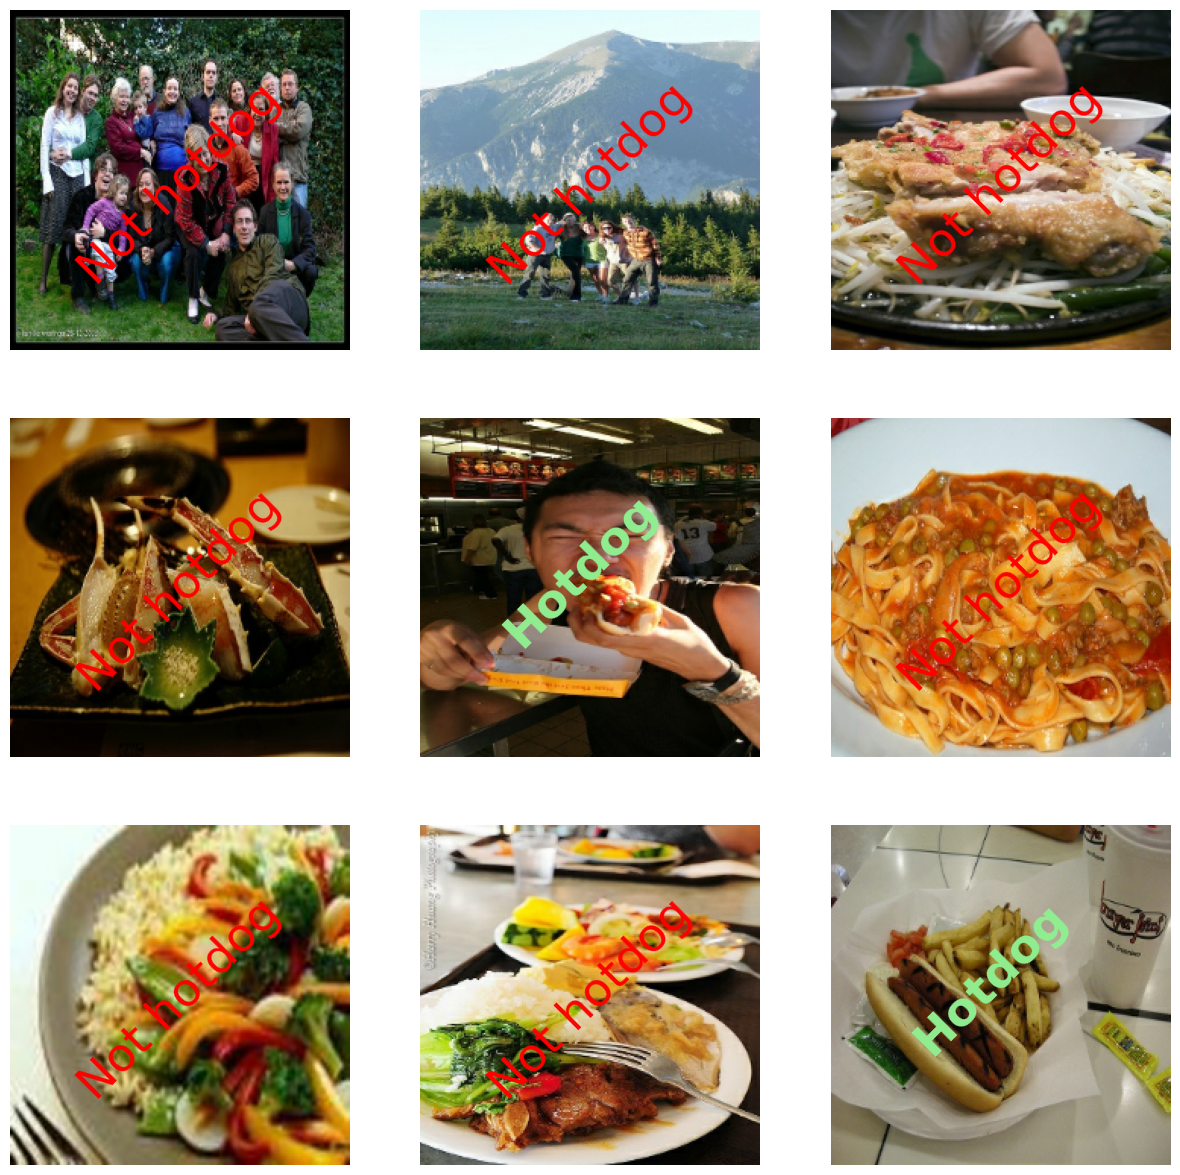

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_efficientNetV2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='hotdog':
        plt.text(50, 150, "Hotdog", rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(40, 180, "Not hotdog", rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")